# Dementia Prediction
- **Dementia** is one of the common causes of memory loss and death gloabally. Many people are not even aware of the fact that they might have dementia or not. Hence, we are driven by this motivation to build machine learning applications that have no unbiasedness and possess high probability of detecting and predicting dementia at any stage.

#### Introduction 
> This project leverages deep learning models(CNN models) for the prediction of Dementia or no Dementia amongst well represented patients samples. 
> This project will make use of pytorch and different CNN models. 
- The best model will be deployed for real usage in medical sectors for dementia prediction 

#### Importing Libraries 

In [33]:
#import methods from the torchvision class
import torch
from sklearn.metrics import accuracy_score
from torchmetrics import Precision, Recall, F1Score
from torchvision.datasets import ImageFolder 
from torchvision import transforms , datasets , models
from torch.utils.data import DataLoader, random_split , WeightedRandomSampler
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 
import os 
from collections import Counter
import torch.nn as nn 

from __future__ import print_function, division
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import copy
import time 

plt.ion()   # This is the interactive mode

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
print(os.path.exists('Alzheimer_dataset/train'))

True


In [35]:
print(os.listdir('Alzheimer_dataset/train'))

['Dementia', 'NonDementia']


### Prior Examination and transformation 
#### Transformation 

In [36]:

#use the transforms object to apply the needed transformation by accessing the Compose class 
#using the transforms object
transform_traindata = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(128, 128)),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((128, 128))
])


#use only the three transform methods
transform_testdata= transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
     transforms.Resize((128, 128))
])

#### Data Collection 

In [37]:
import os

# Path to your dataset directories
train_dir = 'Alzheimer_dataset/train'

# Get the list of class directories
class_dirs = os.listdir(train_dir)

# Initialize a dictionary to store counts
class_counts = {}

for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    # Count the number of files in each class directory
    num_files = len(os.listdir(class_path))
    class_counts[class_name] = num_files

print("Class distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


Class distribution:
Dementia: 2509 images
NonDementia: 2560 images


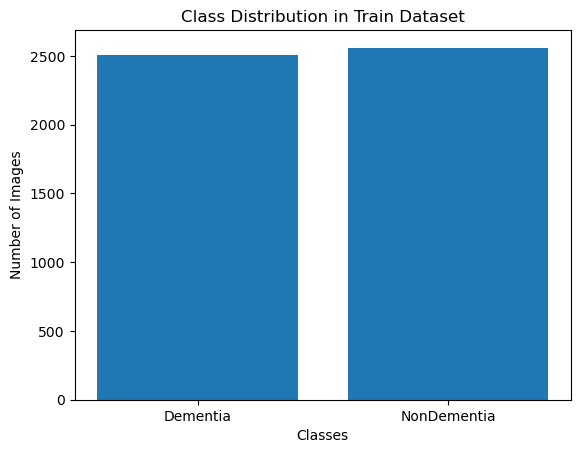

In [38]:
import matplotlib.pyplot as plt

# Extract class names and counts
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Plotting
plt.bar(class_names, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Train Dataset')
plt.show()

In [39]:
train_data = ImageFolder(
    #use the "r" to make python avoid escape issues
  r"C:\Users\512GB\OneDrive\Documents\Research Projects\Dementia Research\Deep-Learning-and-Classical-ML-models-for-Dementia-Prediction\Predicting Dementia\Alzheimer_dataset\train",
  transform = transform_traindata
)

train_size= int(0.8 * len(train_data))
val_size= len(train_data) - train_size

train_dataset, val_dataset= random_split(train_data, [train_size, val_size])

val_dataset.transform= transform_testdata



test = ImageFolder(
    #use the "r" to make python avoid escape issues
  r"C:\Users\512GB\OneDrive\Documents\Research Projects\Dementia Research\Deep-Learning-and-Classical-ML-models-for-Dementia-Prediction\Predicting Dementia\Alzheimer_dataset\test",
  transform = transform_testdata
)   


##### Adjust class imbalance 

In [40]:
# Count the number of samples in each class
class_counts = Counter([label for _, label in train_dataset])
total_samples = len(train_dataset)

# Calculate weights for each class
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Map class labels to indices
class_to_idx = {label: idx for idx, label in enumerate(class_counts.keys())}
labels_list = [class_to_idx[label] for _, label in train_dataset]

# Calculate the weights for each sample
weights = [class_weights[class_counts.most_common()[label_idx][0]] for label_idx in labels_list]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, len(weights))

# Create DataLoader with sampler
dataloader_train = DataLoader(train_dataset, batch_size=20, sampler=sampler)


In [41]:


dataloader_val = DataLoader(
    val_dataset, shuffle= False, batch_size=10, num_workers=2
     
)

dataloader_test= DataLoader(
    test, shuffle=False, batch_size=10, num_workers=2
) 

In [42]:
print(len(dataloader_train))
print(len(dataloader_test))
print(len(dataloader_val))

203
110
102


In [43]:
#get an image and its label
image, label = next(iter(dataloader_train))
#Reshape the image tensor
print(image.shape ) 


torch.Size([20, 3, 128, 128])


In [44]:
#image = image.squeeze().permute(1, 2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

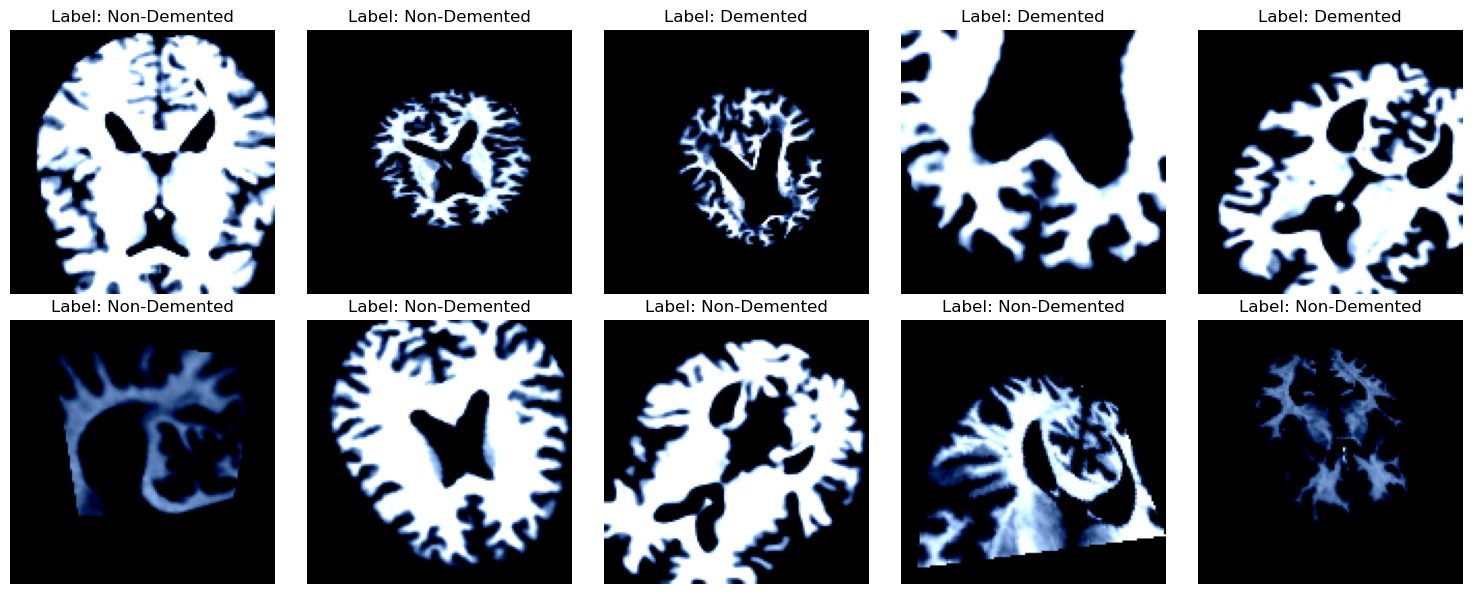

In [45]:
import matplotlib.pyplot as plt

# Define the figure (2 rows with 5 images each) and axis objects
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
# Flatten the axes array
axs = axs.ravel()

# Initialize index for subplots
subplot_index = 0

# Load first 10 examples
for images, labels in dataloader_train:
    if subplot_index >= 10:  # Only plot up to 10 images
        break

    # Plot individual images from the batch
    for j in range(images.size(0)):  # Loop through the batch
        if subplot_index >= 10:  # Stop if we have plotted 10 images
            break
        
        # Extract the j-th image and label from the batch
        image = images[j]  # shape [3, 128, 128]
        label = labels[j]  # Assuming labels is of the same size as images

        # Plot image and set title to the corresponding label
        axs[subplot_index].imshow(image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        axs[subplot_index].title.set_text(f'Label: {"Demented" if label.item() == 0 else "Non-Demented"}')
        axs[subplot_index].axis('off')  # Hide axes for visual appeal

        subplot_index += 1  # Move to the next subplot

plt.tight_layout()
plt.show();


#### Feature Extraction and fully connected layers

In [46]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()
        )

        self.imageclassifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.imageclassifier(x)
        return x


In [47]:
model_inspection = Net(num_classes=1)
print(model_inspection)

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (imageclassifier): Sequential(
    (0): Line

#### Training Loop 

In [48]:
# Initialize the network
net = Net(num_classes=1).to(device)

# Initialize loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Number of epochs
num_epochs = 20

# Lists to store the loss values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def compute_accuracy(predictions, labels):
    preds = torch.round(torch.sigmoid(predictions))  # Apply sigmoid and round to get binary predictions
    correct = (preds == labels).sum().item()
    return correct / len(labels) * 100  # Return percentage accuracy

for epoch in range(num_epochs):
    net.train()  # Set the model to training mode
    running_loss = 0
    all_preds = []
    all_labels = []
    
    # Training loop
    for images, labels in dataloader_train:
        images, labels = images.to(device), labels.to(device).float()  # Ensure labels are [batch_size, 1]
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = net(images)  # Forward pass
        outputs = outputs.squeeze(dim=1)  # Remove the last dimension for consistency
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss
        all_preds.extend(outputs.cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())
    
    epoch_loss = running_loss / len(dataloader_train)
    train_losses.append(epoch_loss)  # Store training loss
    
    train_accuracy = compute_accuracy(torch.tensor(all_preds), torch.tensor(all_labels))
    train_accuracies.append(train_accuracy)  
    
    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_running_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader_val:
            images, labels = images.to(device), labels.to(device).float()   # Ensure labels are [batch_size, 1]
            outputs = net(images)  # Forward pass
            outputs = outputs.squeeze(dim=1)  # Remove the last dimension for consistency
            loss = criterion(outputs, labels)  # Compute loss
            val_running_loss += loss.item()  # Accumulate validation loss
            
            all_val_preds.extend(outputs.cpu().detach().numpy())
            all_val_labels.extend(labels.cpu().detach().numpy())
    
    val_loss = val_running_loss / len(dataloader_val)
    val_losses.append(val_loss)  # Store validation loss
    
    val_accuracy = compute_accuracy(torch.tensor(all_val_preds), torch.tensor(all_val_labels))
    val_accuracies.append(val_accuracy)  
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/20, Train Loss: 1.1705, Train Accuracy: 51.89%, Val Loss: 0.6757, Val Accuracy: 56.80%
Epoch 2/20, Train Loss: 0.6909, Train Accuracy: 58.18%, Val Loss: 0.6541, Val Accuracy: 62.92%
Epoch 3/20, Train Loss: 0.6813, Train Accuracy: 58.89%, Val Loss: 0.6520, Val Accuracy: 65.48%
Epoch 4/20, Train Loss: 0.6593, Train Accuracy: 62.91%, Val Loss: 0.6510, Val Accuracy: 63.12%
Epoch 5/20, Train Loss: 0.6530, Train Accuracy: 63.16%, Val Loss: 0.6380, Val Accuracy: 66.27%
Epoch 6/20, Train Loss: 0.6471, Train Accuracy: 64.12%, Val Loss: 0.6080, Val Accuracy: 66.57%
Epoch 7/20, Train Loss: 0.6477, Train Accuracy: 64.19%, Val Loss: 0.6260, Val Accuracy: 67.36%
Epoch 8/20, Train Loss: 0.6404, Train Accuracy: 63.70%, Val Loss: 0.6182, Val Accuracy: 66.07%
Epoch 9/20, Train Loss: 0.6378, Train Accuracy: 64.46%, Val Loss: 0.7222, Val Accuracy: 62.82%
Epoch 10/20, Train Loss: 0.6535, Train Accuracy: 63.85%, Val Loss: 0.6190, Val Accuracy: 67.06%
Epoch 11/20, Train Loss: 0.6495, Train Accuracy: 

#### Plot the train and val loss curves 

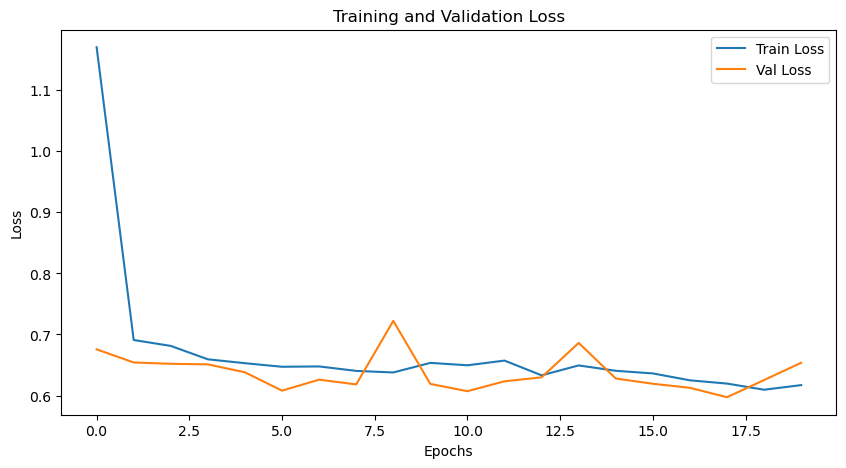

In [49]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5)) 
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.show()

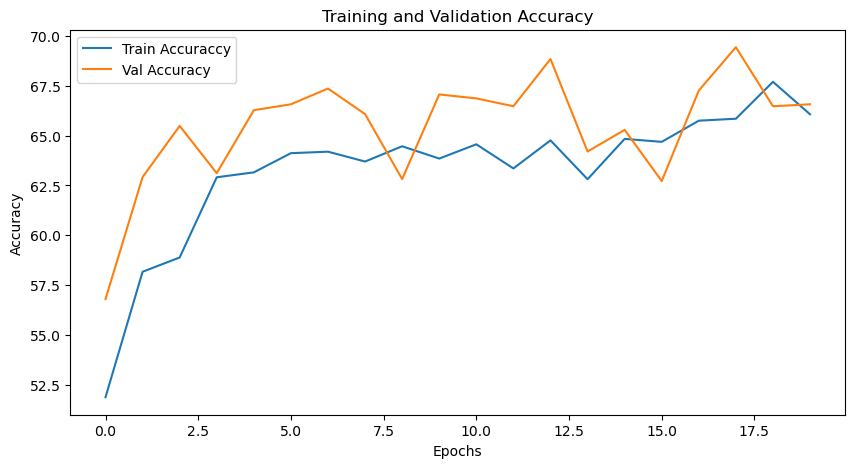

In [50]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5)) 
plt.plot(train_accuracies, label='Train Accuraccy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()
plt.show()

#### Testing Phase

In [51]:
# Test the model after training is complete
net.eval()  # Set the model to evaluation mode
test_running_loss = 0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device).float()  # Ensure labels are [batch_size, 1]
        
        outputs = net(images)  # Forward pass
        outputs = outputs.squeeze(dim=1)  # Remove the last dimension for consistency
        loss = criterion(outputs, labels)  # Compute loss
        test_running_loss += loss.item()  # Accumulate test loss
        
        # Calculate accuracy
        preds = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get binary predictions
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_loss = test_running_loss / len(dataloader_test)
accuracy = correct / total * 100

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.5816, Test Accuracy: 65.66%


#### Evaluation Per class 

Classification Report:
              precision    recall  f1-score   support

Non Demented       0.58      0.66      0.61       458
    Demented       0.73      0.66      0.69       640

    accuracy                           0.66      1098
   macro avg       0.65      0.66      0.65      1098
weighted avg       0.67      0.66      0.66      1098



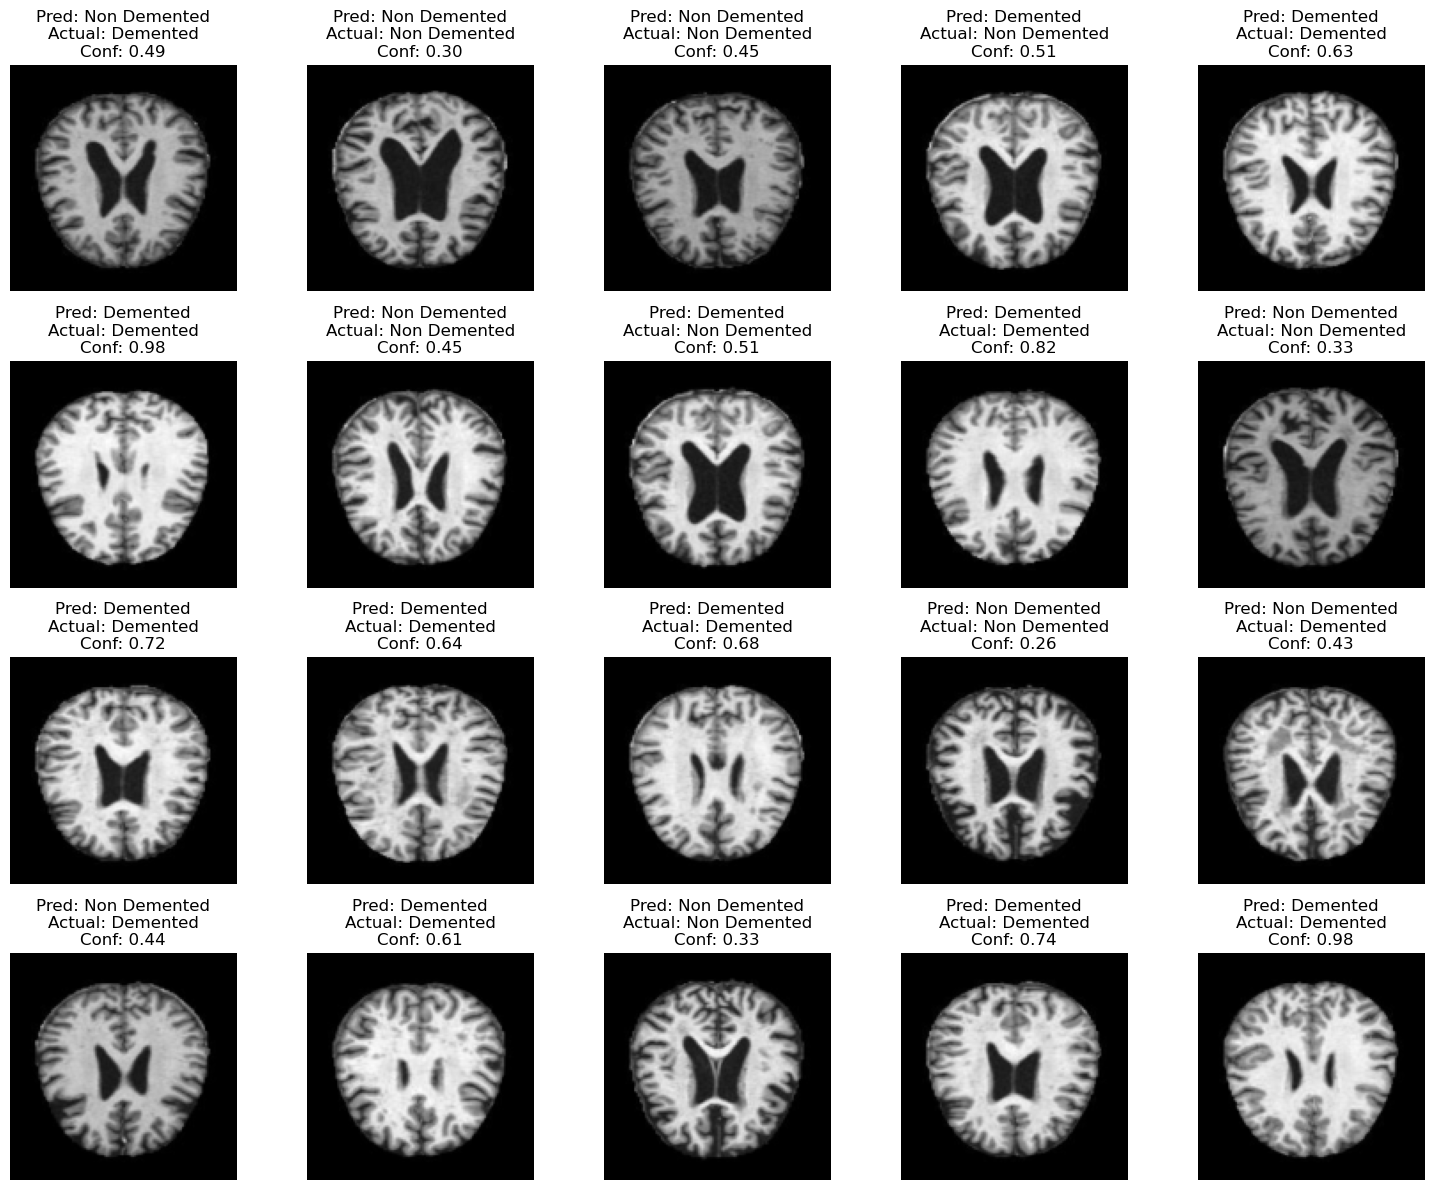

In [52]:
from sklearn.metrics import classification_report

# Testing phase
net.eval()
test_preds = []
test_labels = []
confidence_scores = []
test_images = []

with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device).float()
        outputs = net(images)  # Get logits

        # Compute probabilities using sigmoid for binary classification
        probabilities = torch.sigmoid(outputs)

        # Convert probabilities to binary predictions
        preds = (probabilities > 0.5).long()

        # Extract confidence scores (probabilities) for positive class
        confidence_scores.extend(probabilities.cpu().numpy().flatten())
        test_preds.extend(preds.cpu().numpy().flatten())
        test_labels.extend(labels.cpu().numpy().flatten())
        test_images.extend(images.cpu())

# Convert lists to numpy arrays for sklearn
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
confidence_scores = np.array(confidence_scores)

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Non Demented', 'Demented'], zero_division=0))

# Plotting actual vs predicted images with confidence scores
def imshow(image, ax=None, title=None):
    """Helper function to display an image with title on the specified axis."""
    if ax is None:
        ax = plt.gca() 
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')  # Hide axes

# Select 20 random indices
indices = np.random.choice(len(test_images), 20, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # Adjust size as needed
for i, idx in enumerate(indices):
    ax = axes[i // 5, i % 5]  # Select the correct subplot
    imshow(test_images[idx].cpu().data, ax=ax,
           title=f"Pred: {'Demented' if test_preds[idx] == 1 else 'Non Demented'}\n"
                 f"Actual: {'Demented' if test_labels[idx] == 1 else 'Non Demented'}\n"
                 f"Conf: {confidence_scores[idx]:.2f}")

plt.tight_layout()
plt.show()


##### Plot the distribution of confidence scores 

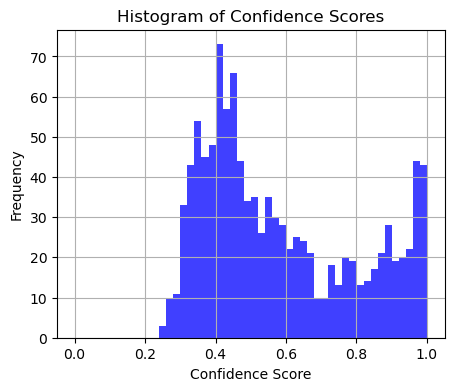

In [53]:

# Histogram of confidence scores
plt.figure(figsize=(5, 4))
plt.hist(confidence_scores, bins=50, range=(0, 1), alpha=0.75, color='blue')
plt.title('Histogram of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### Plot the confusion matrix 

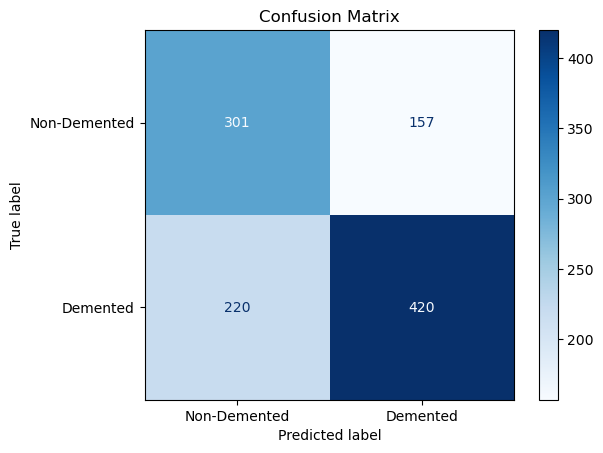

In [54]:
# Confusion matrix with confidence scores
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Demented', 'Demented'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

## Using RESNET 

##### Residual Block

In [55]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
        # Third convolutional layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.downsample = downsample
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Store the input as the residual
        residual = x
        
        # Apply the first convolutional block
        out = self.conv1(x)
        
        # Apply the second convolutional block
        out = self.conv2(out)
        
        # Apply the third convolutional block
        out = self.conv3(out)
        
        # If downsampling is needed, adjust the residual connection
        if self.downsample:
            residual = self.downsample(x)
        
        # Add the residual connection to the output
        out += residual
        
        # Apply the final ReLU activation
        out = self.relu(out)
        
        return out


In [56]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.inplanes = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)  # num_classes should be 1 for binary classification

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


##### Setting Hyperparameters

##### Training Resnet

In [57]:
import gc

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_classes = 1  # Binary classification, output one logit per sample
num_epochs = 20
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-5)



total_step = len(dataloader_train)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(dataloader_train):
        images = images.to(device)
        labels = labels.float().view(-1, 1).to(device)  # Ensure labels are float and reshaped

        # Forward pass 
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply sigmoid and threshold
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        del images, labels, outputs
        torch.cuda.empty_cache() 
        gc.collect()

    avg_train_loss = running_loss / total_step
    train_accuracy = 100 * correct_train / total_train

    # Validation
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in dataloader_val:
            images = images.to(device)
            labels = labels.float().view(-1, 1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(dataloader_val)
    val_accuracy = 100 * correct_val / total_val

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print all metrics for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Epoch [1/20] - Train Loss: 0.8083, Train Accuracy: 51.81% | Val Loss: 0.6979, Val Accuracy: 47.44%
Epoch [2/20] - Train Loss: 0.6913, Train Accuracy: 53.12% | Val Loss: 1.5174, Val Accuracy: 50.30%
Epoch [3/20] - Train Loss: 0.6906, Train Accuracy: 52.55% | Val Loss: 0.6921, Val Accuracy: 52.47%
Epoch [4/20] - Train Loss: 0.6858, Train Accuracy: 55.71% | Val Loss: 0.6939, Val Accuracy: 53.75%
Epoch [5/20] - Train Loss: 0.6854, Train Accuracy: 53.69% | Val Loss: 0.6939, Val Accuracy: 53.25%
Epoch [6/20] - Train Loss: 0.6648, Train Accuracy: 61.04% | Val Loss: 0.6566, Val Accuracy: 62.33%
Epoch [7/20] - Train Loss: 0.6436, Train Accuracy: 63.43% | Val Loss: 0.6600, Val Accuracy: 62.03%
Epoch [8/20] - Train Loss: 0.6379, Train Accuracy: 64.69% | Val Loss: 0.5926, Val Accuracy: 69.23%
Epoch [9/20] - Train Loss: 0.6232, Train Accuracy: 67.05% | Val Loss: 0.6278, Val Accuracy: 65.68%
Epoch [10/20] - Train Loss: 0.6215, Train Accuracy: 65.92% | Val Loss: 0.6325, Val Accuracy: 63.31%
Epoch [11

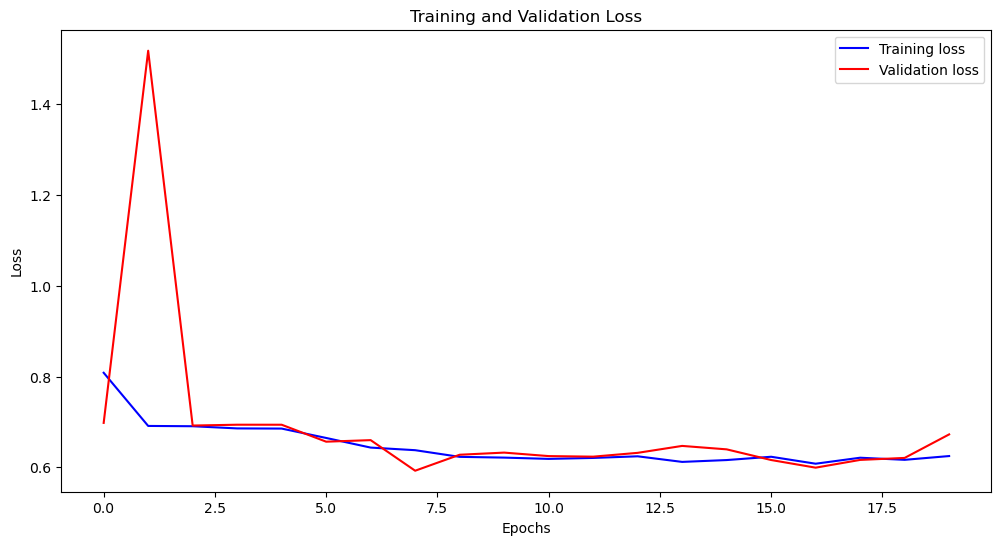

In [58]:


plt.figure(figsize=(12, 6))
# Plot Training and Validation Loss 
plt.plot( train_losses, 'b', label='Training loss')
plt.plot(val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()

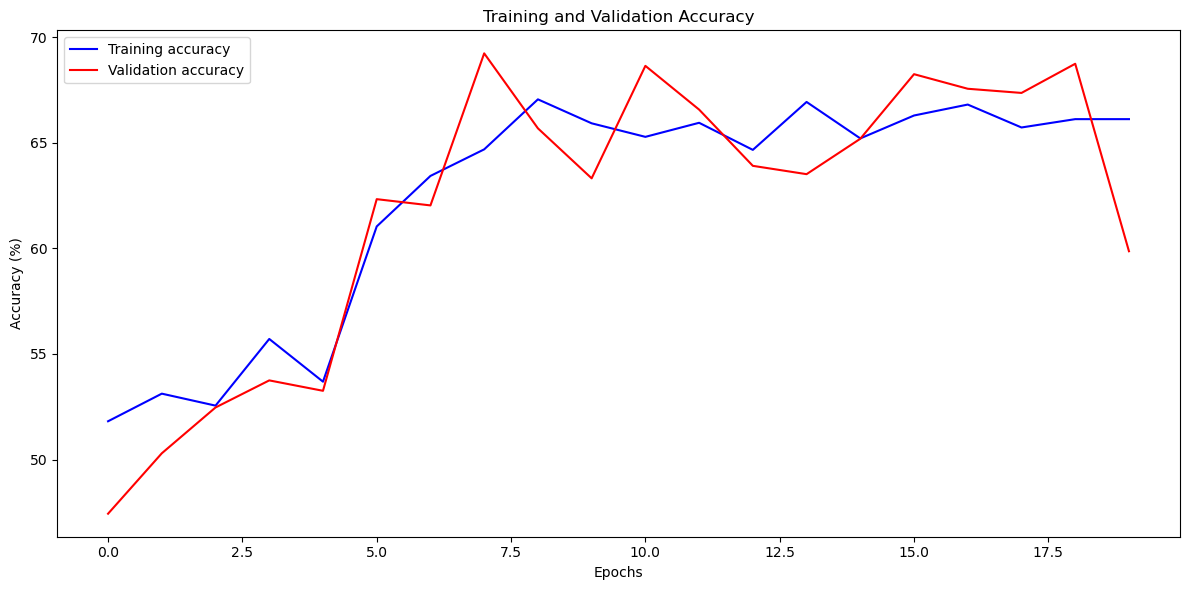

In [59]:

plt.figure(figsize=(12, 6))
# Plot Training and Validation Accuracy
plt.plot( train_accuracies, 'b', label='Training accuracy')
plt.plot(val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

##### Testing ResNet 

Classification Report:
              precision    recall  f1-score   support

Non Demented       0.65      0.09      0.16       458
    Demented       0.60      0.96      0.74       640

    accuracy                           0.60      1098
   macro avg       0.62      0.53      0.45      1098
weighted avg       0.62      0.60      0.50      1098



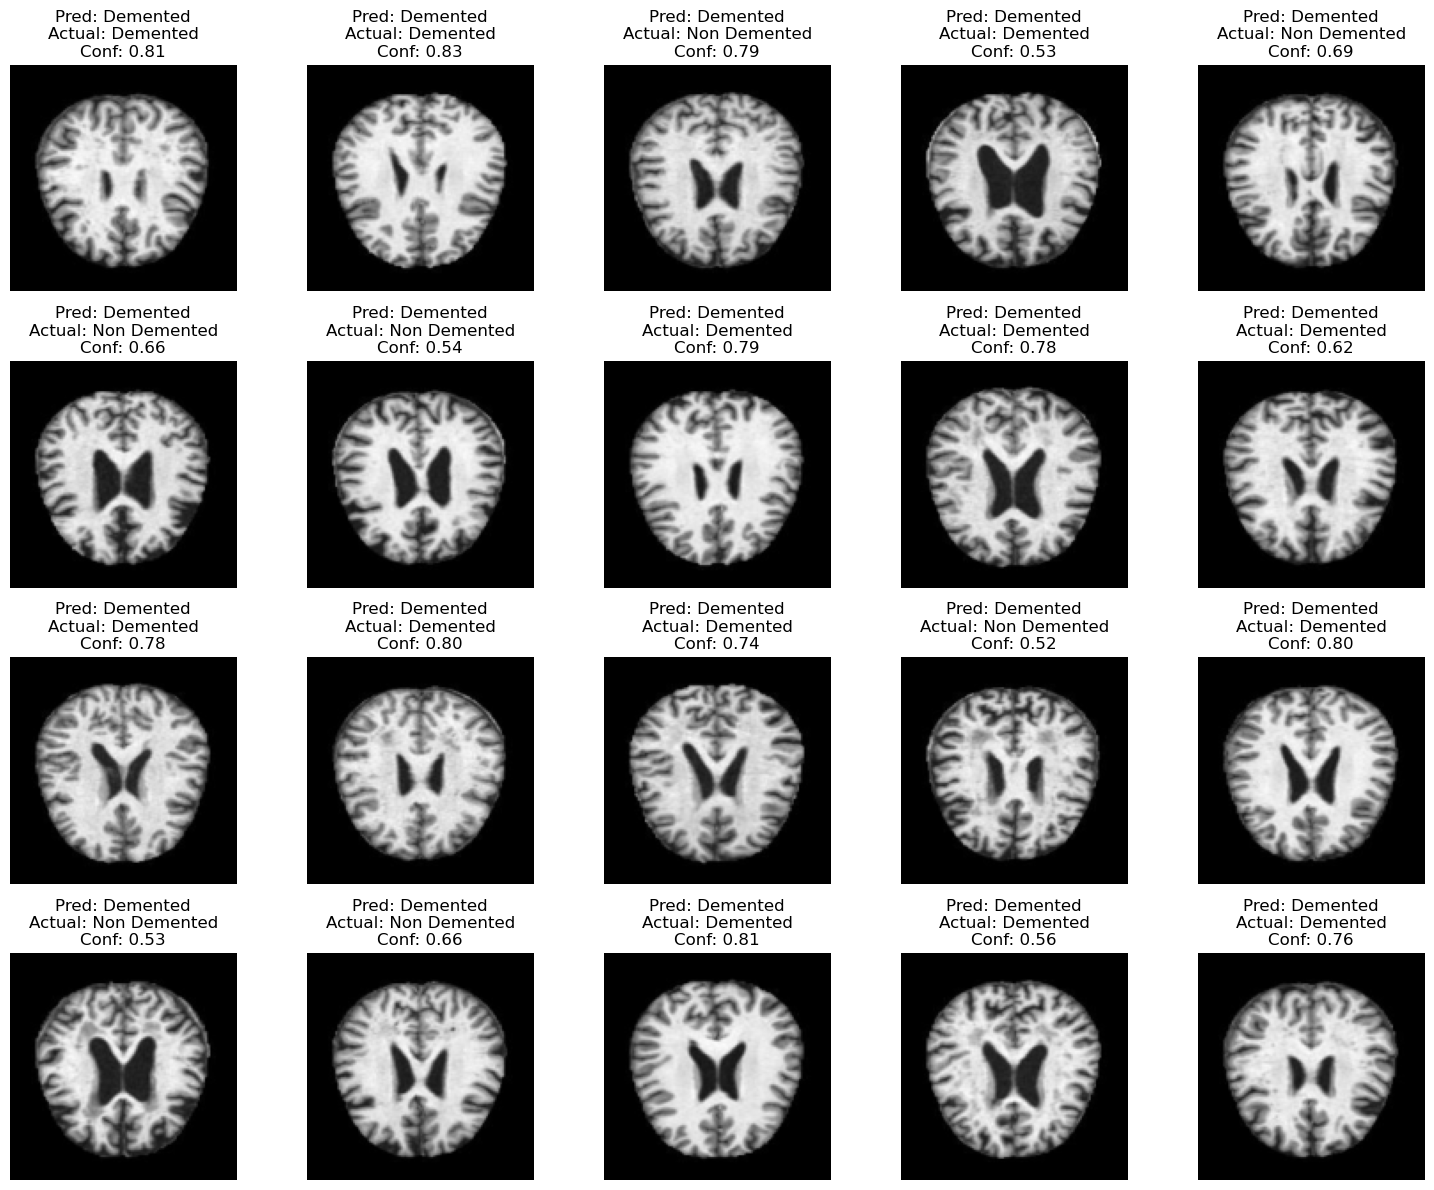

In [61]:
from sklearn.metrics import classification_report

# Testing phase
net.eval()
test_preds = []
test_labels = []
confidence_scores = []
test_images = []

with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images)  # Get logits

        # Compute probabilities using sigmoid for binary classification
        probabilities = torch.sigmoid(outputs)

        # Convert probabilities to binary predictions
        preds = (probabilities > 0.5).long()

        # Extract confidence scores (probabilities) for positive class
        confidence_scores.extend(probabilities.cpu().numpy().flatten())
        test_preds.extend(preds.cpu().numpy().flatten())
        test_labels.extend(labels.cpu().numpy().flatten())
        test_images.extend(images.cpu())

# Convert lists to numpy arrays for sklearn
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
confidence_scores = np.array(confidence_scores)

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Non Demented', 'Demented'], zero_division=0))

# Plotting actual vs predicted images with confidence scores
def imshow(image, ax=None, title=None):
    """Helper function to display an image with title on the specified axis."""
    if ax is None:
        ax = plt.gca() 
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')  # Hide axes

# Select 20 random indices
indices = np.random.choice(len(test_images), 20, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # Adjust size as needed
for i, idx in enumerate(indices):
    ax = axes[i // 5, i % 5]  # Select the correct subplot
    imshow(test_images[idx].cpu().data, ax=ax,
           title=f"Pred: {'Demented' if test_preds[idx] == 1 else 'Non Demented'}\n"
                 f"Actual: {'Demented' if test_labels[idx] == 1 else 'Non Demented'}\n"
                 f"Conf: {confidence_scores[idx]:.2f}")

plt.tight_layout()
plt.show()


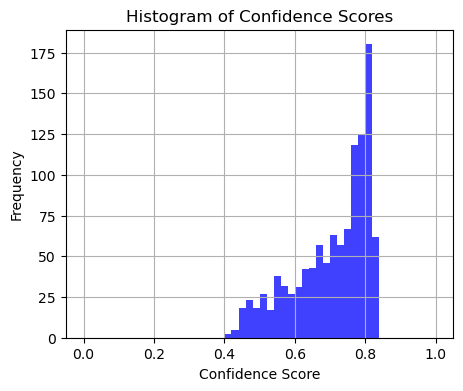

In [62]:

# Histogram of confidence scores
plt.figure(figsize=(5, 4))
plt.hist(confidence_scores, bins=50, range=(0, 1), alpha=0.75, color='blue')
plt.title('Histogram of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Figure size 500x500 with 0 Axes>

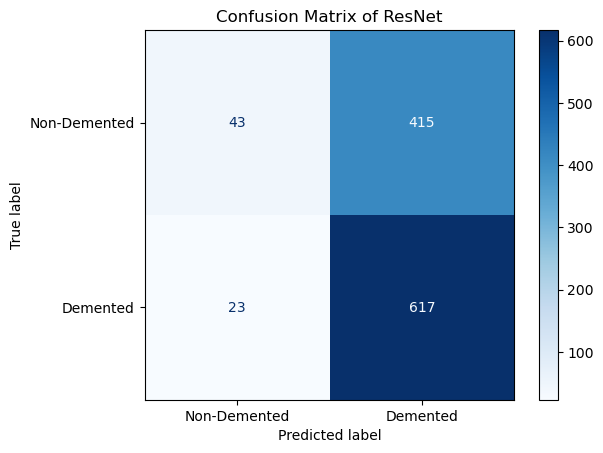

In [66]:
plt.figure(figsize=[5,5])
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Demented', 'Demented'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix of ResNet')
plt.show();

## Using Vision Transformer 

## Using VGGNet

## Hyper Parameter Tuning With Ray Tune (For thes best model)